# Exame the EC-ERA5 Dataset

In the previous notebook, we plot the time-series of the PCA of ERA5 dataset, and found large variations at the end of each year, and stay flat in the rest of the period. This result is unexpected, and may cause problems in further analysis. Therefore, we will explore the dataset in this notebook.

(14607, 20)
Index(['mslp_pc1', 'mslp_pc2', 'mslp_pc3', 'mslp_pc4', 'mslp_pc5', 'mslp_pc6',
       'mslp_pc7', 'mslp_pc8', 'mslp_pc9', 'mslp_pc10', 'mslp_pc11',
       'mslp_pc12', 'mslp_pc13', 'mslp_pc14', 'mslp_pc15', 'mslp_pc16',
       'mslp_pc17', 'mslp_pc18', 'mslp_pc19', 'mslp_pc20'],
      dtype='object')


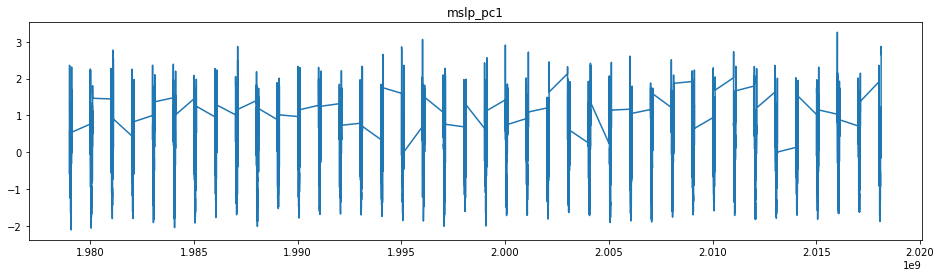

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Defined Parameters
PROJPATH = '../data/pca_era5/projection/'
PROJSUFFIX = '.proj.csv'
LAYERS = ['mslp', 'q925','t925','u925','v925','q850','t850','u850','v850','q700','t700','u700','v700','h500','u200','v200']

def read_20_pcs(fname, varname=''):
    ''' Read PCs from specified file.'''
    import pandas as pd
    import numpy as np
    data = pd.read_csv(fname, index_col=0)
    data = data.iloc[:,:20]
    data.columns = [varname+"pc"+str(i+1) for i in range(20)]
    return(data)

tmp = read_20_pcs(PROJPATH+LAYERS[0]+PROJSUFFIX, LAYERS[0]+'_')

print(tmp.shape)
print(tmp.columns)

plt.figure(figsize=(16,4))
plt.plot(tmp['mslp_pc1'])
plt.title('mslp_pc1')
plt.show()

Since this strange kink appeared in all 16 characteristic layers, we can start with any one layer. Let's just work on the MSLP.

First, we will check the basic statistics of the raw data, such as mean, variance, and number of missing data.

In [2]:
# Utility functions
def list_era5_files(dir, suffix='.nc'):
    ''' To scan through the sapecified dir and get the corresponding file with suffix. '''
    import os
    import pandas as pd
    xfiles = []
    for root, dirs, files in os.walk(dir, followlinks=True):    # Loop through the directory
        for fn in files:
            if fn.endswith(suffix):                             # Filter files with suffix
                timestamp = fn.replace(suffix,'')[:10]          # Removing the suffix to get time-stamp
                xfiles.append({'timestamp':timestamp, 'xuri':os.path.join(root, fn)})
    return(pd.DataFrame(xfiles).sort_values('timestamp').reset_index(drop=True))

# Binary reader
def read_era5_singlevar(furi):
    ''' The method reads in a ERA5 single variable in netCDF4 format (.nc file). 
        Rhe data domain focuss on East Asia (10-50'N, 100-140'E), and the output 
        is a 2-d numpy array of float32 with shape (161, 161).
    '''
    import numpy as np
    import netCDF4 as nc
    # Read in data
    data = nc.Dataset(furi)
    varname = list(data.variables.keys())[-1]
    var = np.array(data.variables[varname])
    # Done
    return(var[0,:,:])

# Derive basic statistics
def calc_basic_stats(data):
    import numpy as np
    m = np.mean(data.flatten())
    s = np.std(data.flatten())
    return((m,s))

In [5]:
DATAPATH = '../data/era5/mslp/'
datainfo = list_era5_files(DATAPATH, suffix='.nc')
print(datainfo.head())

ms = []
ss = []

for i in range(datainfo.shape[0]):
    tmp = read_era5_singlevar(datainfo['xuri'].iloc[i])
    m,s = calc_basic_stats(tmp)
    ms.append(m)
    ss.append(s)

datastats = pd.DataFrame({'date':datainfo['timestamp'], 'mean':ms, 'stdev':ss})
print(datastats.head())

    timestamp                                  xuri
0  1979010100  ../data/era5/mslp/1979010100_mslp.nc
1  1979010200  ../data/era5/mslp/1979010200_mslp.nc
2  1979010300  ../data/era5/mslp/1979010300_mslp.nc
3  1979010400  ../data/era5/mslp/1979010400_mslp.nc
4  1979010500  ../data/era5/mslp/1979010500_mslp.nc
         date           mean       stdev
0  1979010100  102164.195312  786.539429
1  1979010200  102093.046875  586.081726
2  1979010300  102169.976562  518.129578
3  1979010400  102007.945312  443.142944
4  1979010500  101550.562500  746.329224


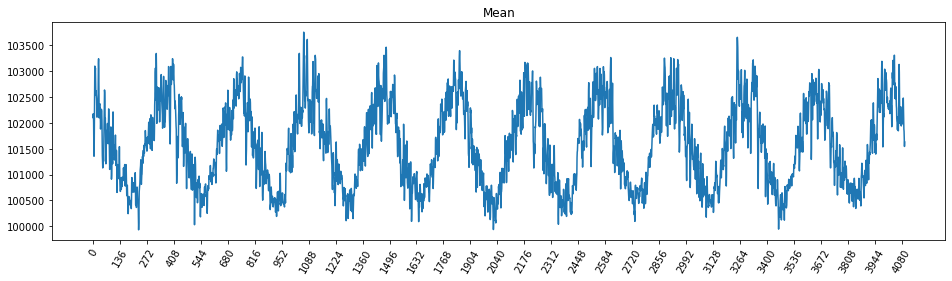

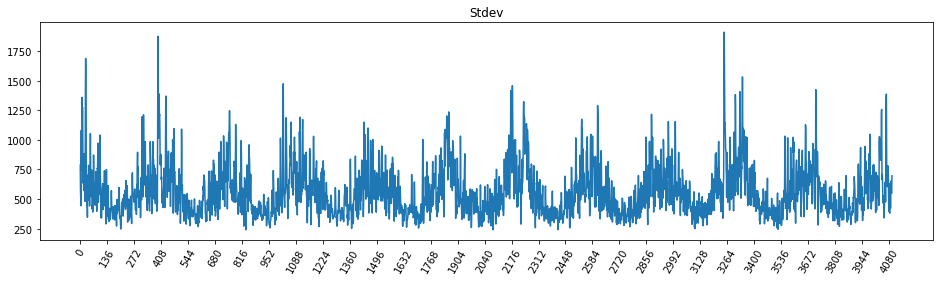

In [7]:
day0 = 0
ndays = 4096
tmp = datastats.iloc[day0:day0+ndays,:]

plt.figure(figsize=(16,4))
plt.plot(tmp['mean'])
plt.xticks(np.arange(0, ndays, step=int(ndays/30)), rotation=60) 
plt.title('Mean')
plt.show()

plt.figure(figsize=(16,4))
plt.plot(tmp['stdev'])
plt.xticks(np.arange(0, ndays, step=int(ndays/30)), rotation=60) 
plt.title('Stdev')
plt.show()

After checking several periods, there seemed no problems with the mean and variance of the map. The MSLP is always low in summer and high in winter, and its variations are slightly off-phase with the mean. 

Next, we shall check the PCA with smaller samples.

## Divide the Dataset

In [8]:
# Check index
ts = list(datainfo['timestamp'])
print('Total days: ' + str(len(ts)))
print('Last date: ' + str(ts[-1]))
print('Entry of 2018010100: ' + str(ts.index('2018010100')))
print('Entry of 2016010100: ' + str(ts.index('2016010100')))
print('Entry of 2014010100: ' + str(ts.index('2014010100')))
print('Entry of 2009010100: ' + str(ts.index('2009010100')))
print('Entry of 1999010100: ' + str(ts.index('1999010100')))

Total days: 14607
Last date: 2018123100
Entry of 2018010100: 14242
Entry of 2016010100: 13511
Entry of 2014010100: 12781
Entry of 2009010100: 10955
Entry of 1999010100: 7302


In [10]:
from sklearn.decomposition import PCA, IncrementalPCA

def read_multiple_era5(flist, flatten=False):
    ''' This method reads in a list of NOAA-GridSat-B1 images and returns a numpy array. '''
    import numpy as np
    data = []
    for f in flist:
        tmp = read_era5_singlevar(f)
        if flatten:
            tmp = tmp.flatten()
        data.append(tmp)
    return(np.array(data))

def fit_pca(finfo, n_component=20):
    ''' Initial and fit a PCA model with incremental PCA. '''
    # Initialize the PCA object
    pca = PCA(n_components=n_component, whiten=True)
    data = read_multiple_era5(finfo['xuri'], flatten=True)
    proj = pca.fit_transform(data)
    #
    return(proj, pca)

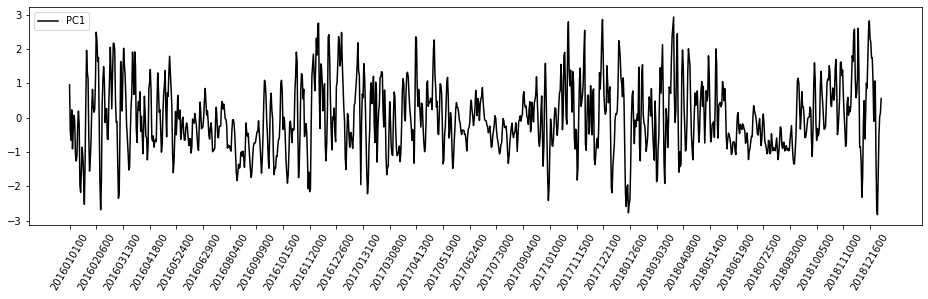

In [27]:
# Test 2016~2018
tmp = datainfo.iloc[13511:,:]
proj, pca = fit_pca(tmp)

print(proj.shape)

df = pd.DataFrame(proj)
df.index = tmp['timestamp']
df.columns = ['pc_'+str(i) for i in range(20)]

plt.figure(figsize=(16,4))
plt.plot(df['pc_1'], color='black', ls='solid', label='PC1')
#plt.plot(df['pc_2'], color='blue', ls='dashed', label='PC2')
#plt.plot(df['pc_3'], color='green', ls='dotted', label='PC3')
plt.xticks(np.arange(0, df.shape[0], step=int(df.shape[0]/30)), rotation=60) 
plt.title('PC1 of MSLP in 2016~2018')
plt.legend()
plt.show()

(1826, 20)


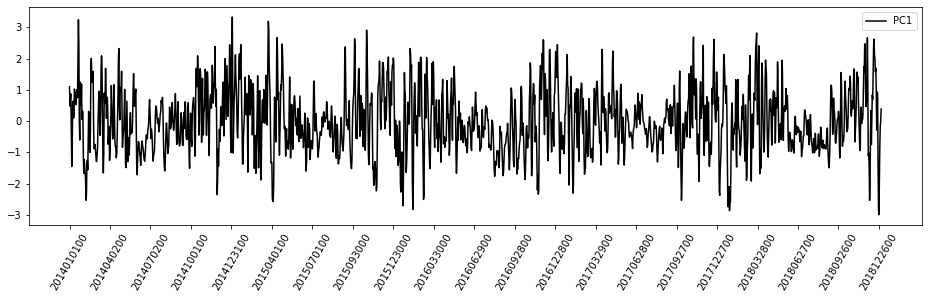

In [29]:
# Test 2014~2018
tmp = datainfo.iloc[12781:,:]
proj, pca = fit_pca(tmp)

print(proj.shape)

df = pd.DataFrame(proj)
df.index = tmp['timestamp']
df.columns = ['pc_'+str(i) for i in range(20)]

plt.figure(figsize=(16,4))
plt.plot(df['pc_1'], color='black', ls='solid', label='PC1')
#plt.plot(df['pc_2'], color='blue', ls='dashed', label='PC2')
#plt.plot(df['pc_3'], color='green', ls='dotted', label='PC3')
plt.xticks(np.arange(0, df.shape[0], step=int(df.shape[0]/20)), rotation=60) 
plt.title('PC1 of MSLP in 2014~2018')
plt.legend()
plt.show()

(3652, 20)


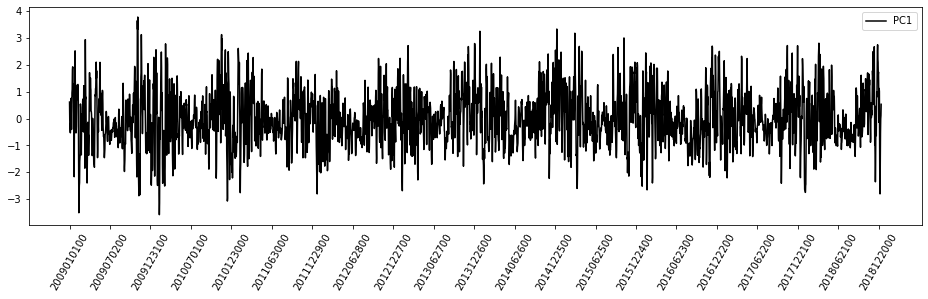

In [30]:
# Test 2009~2018
tmp = datainfo.iloc[10955:,:]
proj, pca = fit_pca(tmp)

print(proj.shape)

df = pd.DataFrame(proj)
df.index = tmp['timestamp']
df.columns = ['pc_'+str(i) for i in range(20)]

plt.figure(figsize=(16,4))
plt.plot(df['pc_1'], color='black', ls='solid', label='PC1')
#plt.plot(df['pc_2'], color='blue', ls='dashed', label='PC2')
#plt.plot(df['pc_3'], color='green', ls='dotted', label='PC3')
plt.xticks(np.arange(0, df.shape[0], step=int(df.shape[0]/20)), rotation=60) 
plt.title('PC1 of MSLP in 2009~2018')
plt.legend()
plt.show()

(7305, 20)


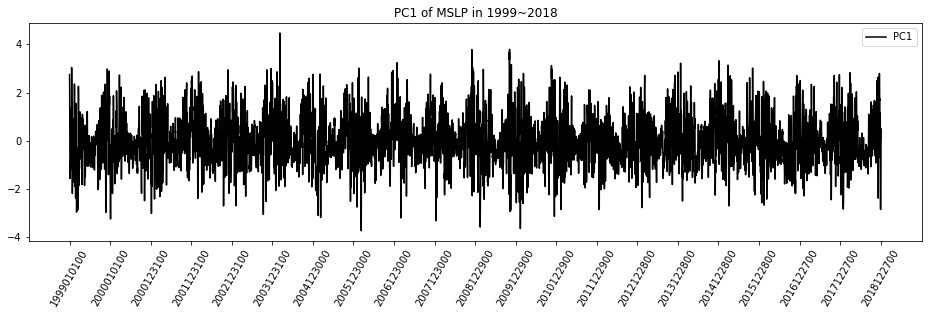

In [32]:
# Test 1999~2018
tmp = datainfo.iloc[7302:,:]
proj, pca = fit_pca(tmp)

print(proj.shape)

df = pd.DataFrame(proj)
df.index = tmp['timestamp']
df.columns = ['pc_'+str(i) for i in range(20)]

plt.figure(figsize=(16,4))
plt.plot(df['pc_1'], color='black', ls='solid', label='PC1')
#plt.plot(df['pc_2'], color='blue', ls='dashed', label='PC2')
#plt.plot(df['pc_3'], color='green', ls='dotted', label='PC3')
plt.xticks(np.arange(0, df.shape[0], step=int(df.shape[0]/20)), rotation=60)
plt.title('PC1 of MSLP in 1999~2018')
plt.legend()
plt.show()

(14607, 3)


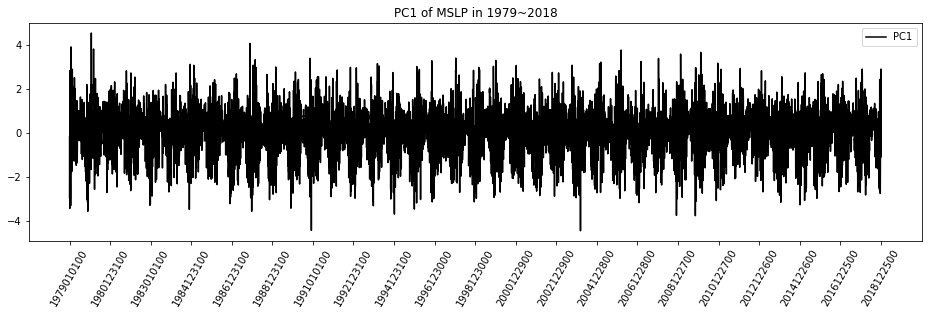

In [11]:
# Test 1979~2018
tmp = datainfo
proj, pca = fit_pca(tmp, n_component=3)

print(proj.shape)

df = pd.DataFrame(proj)
df.index = tmp['timestamp']
df.columns = ['pc_'+str(i) for i in range(proj.shape[1])]

plt.figure(figsize=(16,4))
plt.plot(df['pc_1'], color='black', ls='solid', label='PC1')
#plt.plot(df['pc_2'], color='blue', ls='dashed', label='PC2')
#plt.plot(df['pc_3'], color='green', ls='dotted', label='PC3')
plt.xticks(np.arange(0, df.shape[0], step=int(df.shape[0]/20)), rotation=60)
plt.title('PC1 of MSLP in 1979~2018')
plt.legend()
plt.show()

The full PCA seems OK comparing to IncrementalPCA. It's possible that a random shuffle of the cases somehow eliminate the smaller variations onther than winter. We will re-do the PCA again before we proceed further.

In [12]:
df.head()

,pc_0,pc_1,pc_2
timestamp,,,
1979010100,0.579712,-2.964277,0.555240
1979010200,0.474585,-1.830133,-0.755065
1979010300,0.671188,-0.163907,-1.344020
1979010400,0.481358,-0.987164,0.898581
1979010500,-0.236751,-2.490308,-0.426082


In [13]:
df.to_csv('test.csv')

    timestamp      pc_0      pc_1      pc_2
0  1979010100  0.579712 -2.964277  0.555240
1  1979010200  0.474585 -1.830133 -0.755065
2  1979010300  0.671189 -0.163907 -1.344020
3  1979010400  0.481358 -0.987164  0.898581
4  1979010500 -0.236751 -2.490308 -0.426082


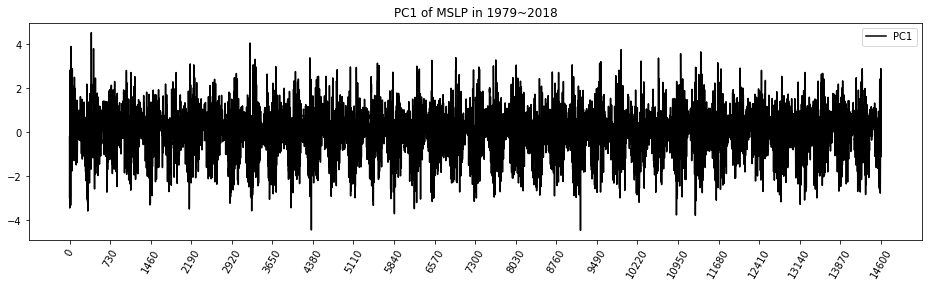

In [14]:
# Test reload projection from file
tmp = pd.read_csv('test.csv')
print(tmp.head())

plt.figure(figsize=(16,4))
plt.plot(tmp['pc_1'], color='black', ls='solid', label='PC1')
plt.xticks(np.arange(0, tmp.shape[0], step=int(tmp.shape[0]/20)), rotation=60)
plt.title('PC1 of MSLP in 1979~2018')
plt.legend()
plt.show()

    timestamp         0         1         2
0  1979010100  0.579712 -2.964290  0.555238
1  1979010200  0.474586 -1.830130 -0.755074
2  1979010300  0.671189 -0.163904 -1.344011
3  1979010400  0.481358 -0.987164  0.898582
4  1979010500 -0.236751 -2.490302 -0.426089


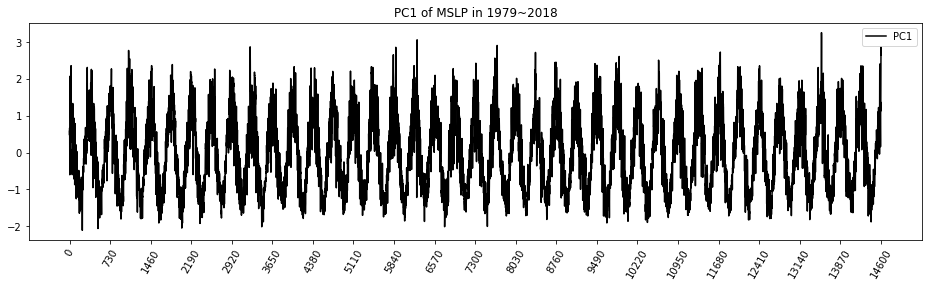

In [22]:
tmp2 = pd.read_csv('../data/pca_era5/projection/mslp.proj.csv').iloc[:,:4]
print(tmp2.head())

plt.figure(figsize=(16,4))
plt.plot(tmp2.iloc[:,1], color='black', ls='solid', label='PC1')
plt.xticks(np.arange(0, tmp2.shape[0], step=int(tmp2.shape[0]/20)), rotation=60)
plt.title('PC1 of MSLP in 1979~2018')
plt.legend()
plt.show()

In [28]:
diff = tmp['pc_0'] - tmp2['0']

print(diff)

diff.describe()

#plt.figure(figsize=(16,4))
#plt.plot(diff, color='black', ls='solid', label='PC1')
#plt.xticks(np.arange(0, tmp2.shape[0], step=int(tmp2.shape[0]/20)), rotation=60)
#plt.title('PC1 of MSLP in 1979~2018')
#plt.legend()
#plt.show()

0        0.000000e+00
1       -5.600000e-07
2       -7.500000e-07
3       -2.100000e-07
4        1.500000e-07
             ...     
14602   -2.000000e-06
14603   -2.100000e-06
14604   -2.400000e-06
14605   -2.700000e-06
14606   -2.400000e-06
Length: 14607, dtype: float64


count    1.460700e+04
mean    -7.081535e-12
std      7.770336e-07
min     -3.000000e-06
25%     -6.000000e-07
50%      4.000000e-08
75%      6.300000e-07
max      1.900000e-06
dtype: float64

After checking, the calculation should be correct (max-difference is $10^{-6}$). The figure **looks** wrong may be caused by some plotting parameters.